In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
n_classes = len(class_names)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 8, 14, 13, 12, 12,  2,  2,  0, 12, 13, 12,  7, 12,  8,  5, 12, 12,
       12,  3, 10, 12,  1,  7,  5,  3,  6, 11,  0, 14,  8, 13,  5],
      dtype=int32)>>


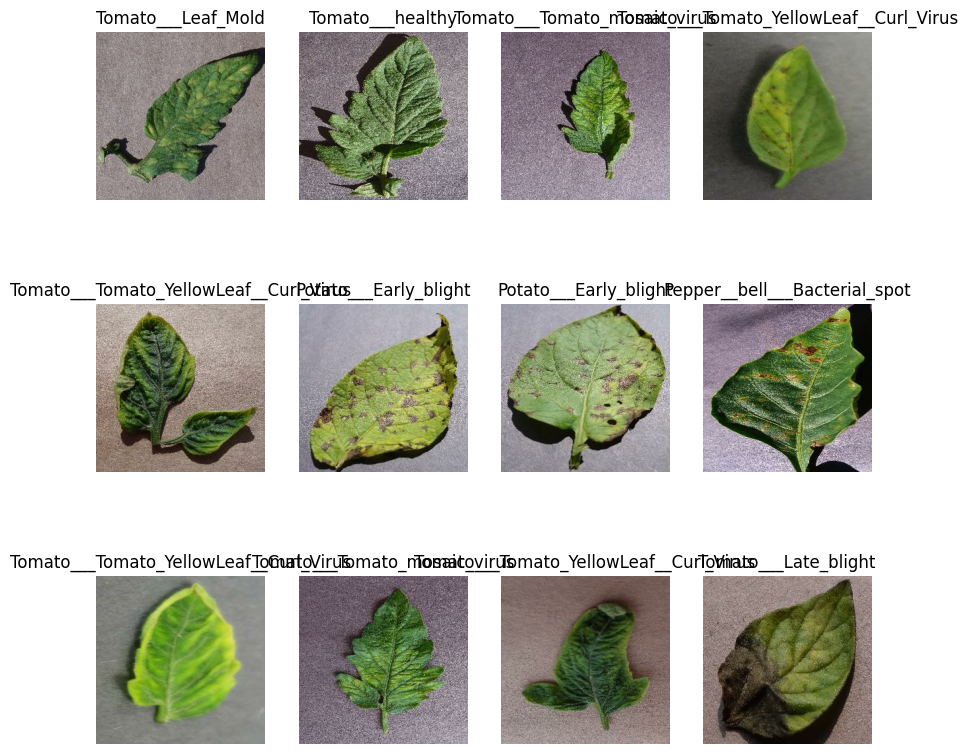

In [5]:
plt.figure(figsize=(10,10))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy)
    
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [6]:
train_size = 0.8
len(dataset)*train_size

516.0

In [7]:
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)
len(train_ds)

516

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

591

In [9]:
val_size = 0.1
len(dataset)*val_size

64.5

In [10]:
test_ds = test_ds.skip(6)
len(test_ds)

585

In [11]:
def get_dataset_partition_tf(ds, train_split=0.8,val_split =0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) ==1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).skip(val_size)   
    return train_ds, val_ds, test_ds     

In [12]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)   

In [13]:
len(train_ds)

516

In [14]:
len(val_ds)

65

In [15]:
len(test_ds)

585

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [17]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.5529412  0.53333336 0.54901963]
  [0.5686275  0.54901963 0.5647059 ]
  [0.59607846 0.5764706  0.5921569 ]
  ...
  [0.6901961  0.6862745  0.70980394]
  [0.7647059  0.7607843  0.78431374]
  [0.6156863  0.6117647  0.63529414]]

 [[0.54509807 0.5254902  0.5411765 ]
  [0.5411765  0.52156866 0.5372549 ]
  [0.57254905 0.5529412  0.5686275 ]
  ...
  [0.64705884 0.6431373  0.6666667 ]
  [0.654902   0.6509804  0.6745098 ]
  [0.7490196  0.74509805 0.76862746]]

 [[0.50980395 0.49019608 0.5058824 ]
  [0.4862745  0.46666667 0.48235294]
  [0.5176471  0.49803922 0.5137255 ]
  ...
  [0.7019608  0.69803923 0.72156864]
  [0.7529412  0.7490196  0.77254903]
  [0.7294118  0.7254902  0.7490196 ]]

 ...

 [[0.41960785 0.4117647  0.42352942]
  [0.41568628 0.40784314 0.41960785]
  [0.4117647  0.40392157 0.41568628]
  ...
  [0.62352943 0.6156863  0.63529414]
  [0.62352943 0.6156863  0.63529414]
  [0.61960787 0.6117647  0.6313726 ]]

 [[0.41960785 0.4117647  0.42352942]
  [0.41568628 0.40784314 0.41960785]


In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])


In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [20]:
model = models.Sequential([

    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),

    layers.Rescaling(1./255),

    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu'),  # NEW LAYER
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),   # 🔥 VERY IMPORTANT

    layers.Dense(n_classes, activation='softmax')
])



In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,237,583 (50.50 MB)

 Trainable params: 13,237,583 (50.50 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
130/516 ━━━━━━━━━━━━━━━━━━━━ 15:57 2s/step - accuracy: 0.1849 - loss: 2.6074

In [ ]:
len(test_ds)

585

In [ ]:
scores = model.evaluate(test_ds)

585/585 ━━━━━━━━━━━━━━━━━━━━ 245s 278ms/step - accuracy: 0.9733 - loss: 0.2691


In [ ]:
scores

[0.26907962560653687, 0.973341166973114]

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

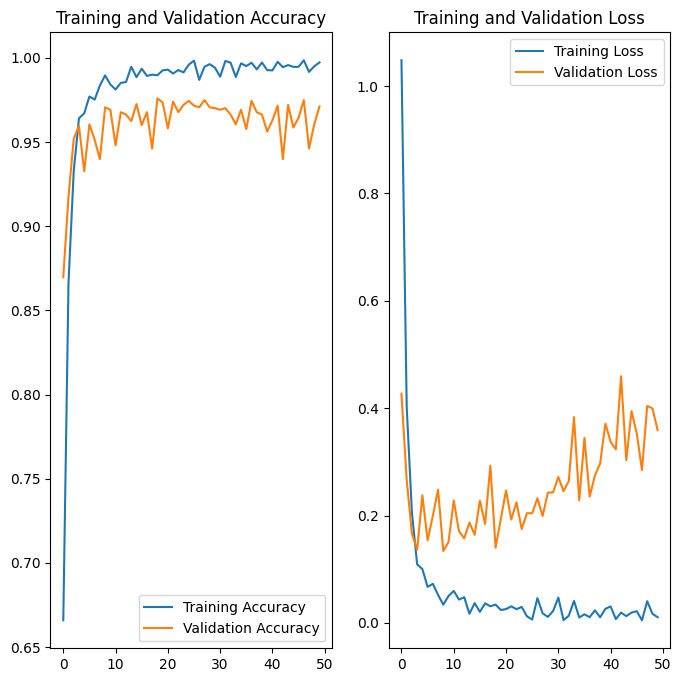

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Tomato__Tomato_mosaic_virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
Predicted Label: Tomato__Tomato_mosaic_virus


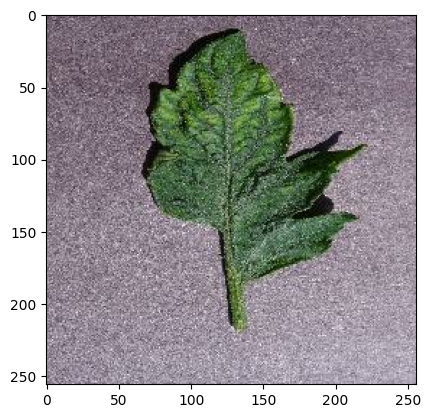

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])



In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


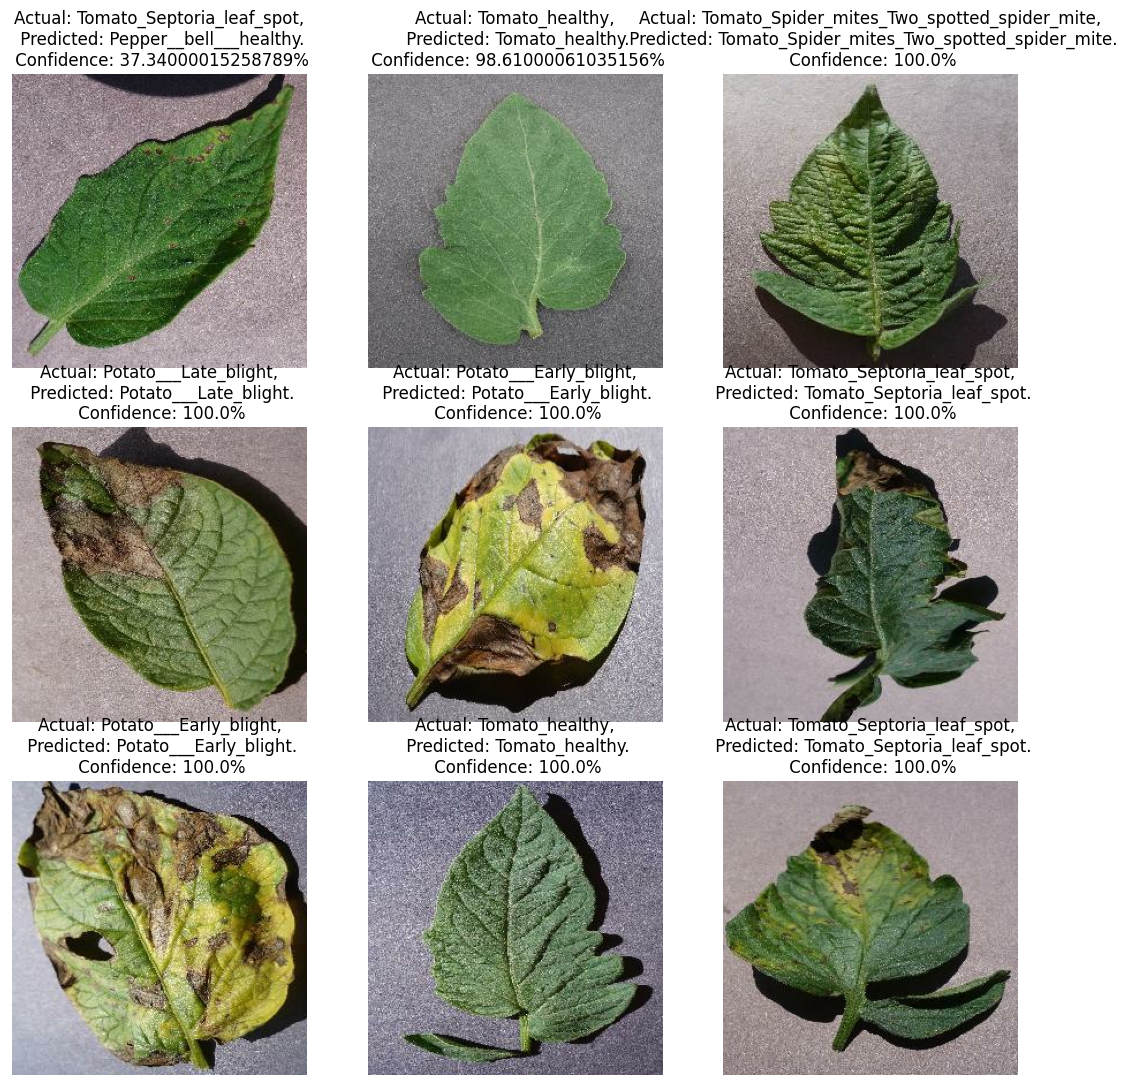

In [ ]:
plt.figure(figsize=(13,13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [42]:
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])


NameError: name 'history' is not defined

In [ ]:
model.save("models/3.keras")